# Requirements 📋✅

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
# import cv2

# Needed for the data
from sklearn.model_selection import train_test_split
from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import convert_to_tensor
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.models import load_model as tfk__load_model
import tensorflow as tf


2024-02-24 18:44:13.747913: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 18:44:13.747991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 18:44:13.749032: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-24 18:44:13.755829: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-24 18:44:14.885946: W tensorflow/compiler/tf2

In [2]:
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
from tensorflow import convert_to_tensor


# Hopefully fixing cuda

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


In [4]:
!echo $CUDA_VISIBLE_DEVICES


1


# The Dataset location 📍

## Label Data Load ⏳

In [8]:
# params
batch_size = 32
img_height = 256
img_width = 256
validation_split = 0.2
num_classes = 4


In [8]:
train_dataset = image_dataset_from_directory(
    directory='/home/kyrill/code/pt-ai/pt-ai/raw_data/processed_data_03',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    validation_split=validation_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 4772 files belonging to 4 classes.
Using 3818 files for training.


2023-12-01 14:09:02.421058: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [9]:
validation_dataset = image_dataset_from_directory(
    directory='/home/kyrill/code/pt-ai/pt-ai/raw_data/processed_data_03',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    validation_split=validation_split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 4772 files belonging to 4 classes.
Using 954 files for validation.


In [10]:
type(train_dataset)


tensorflow.python.data.ops.prefetch_op._PrefetchDataset

## Preprocessing ⚙️

### CNN Model Function 🦾💻🧠

In [11]:
def initialize_CNN():
    model = models.Sequential()

    # Preprocessing layers
    model.add(layers.CenterCrop(height=350, width=450, input_shape=[256,256,1]))

    # Build of the Model
    model.add(layers.Conv2D(filters=8, kernel_size=(4,4), activation='relu', padding='same'))
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Conv2D(16,(3,3), activation='relu'))
    model.add(layers.MaxPool2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))

    # Compilation of the Model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [12]:
# Summary of the CNN model
tmp_first_CNN = initialize_CNN()
tmp_first_CNN.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop (CenterCrop)    (None, 350, 450, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 350, 450, 8)       136       
                                                                 
 max_pooling2d (MaxPooling2  (None, 175, 225, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 173, 223, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 86, 111, 16)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 152736)            0

In [15]:
es = EarlyStopping(patience=1, restore_best_weights=True)


In [17]:
history = tmp_first_CNN.fit(train_dataset,
                            epochs=1,
                            validation_data=validation_dataset,
                            batch_size=16,
                            callbacks=[es])


120/120 [==============================] - 195s 2s/step - loss: 1.3670 - accuracy: 0.3279 - val_loss: 1.3507 - val_accuracy: 0.3532


In [18]:
tmp_first_CNN.evaluate(validation_dataset)


30/30 [==============================] - 9s 285ms/step - loss: 1.3507 - accuracy: 0.3532


[1.350656270980835, 0.3532494902610779]

In [6]:
from PIL import Image


In [99]:
def preprocessing_images(image_path):
    pred_image = Image.open(image_path)
    X_pred = np.array(pred_image)
    X_pred = tf.convert_to_tensor(X_pred, dtype=tf.float32)
    X_pred = tf.image.rot90(X_pred, k=-1)

    X_pred = X_pred[:,:,:3]/255.
    X_pred = tf.image.resize_with_pad(X_pred, 256,256)
    X_pred = rgb_to_grayscale(X_pred)

    X_pred = tf.expand_dims(X_pred, axis=0)

    # plt.imshow(rgb_to_grayscale(X_pred[:,:,:3]/255.), cmap='gray')
    return X_pred


In [128]:
preprocessing_images('../raw_data/test_images/IMG_8806.jpg')


<tf.Tensor: shape=(1, 256, 256, 1), dtype=float32, numpy=
array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]], dtype=float32)>

In [118]:
def prediction_model(model, image_preprocessed):
    """Try and predict an image from the Dataset"""

    y_pred = model.predict(image_preprocessed)
    print(f'✅ Prediction complete. Pose: {y_pred}')
    return y_pred


In [127]:
fitted_model = tfk__load_model('../raw_data/models/model.h5')
res1 = prediction_model(fitted_model, preprocessing_images('../raw_data/test_images/IMG_8803 (1).jpg'))
res2 = prediction_model(fitted_model, preprocessing_images('../raw_data/test_images/IMG_8804.jpg'))
res3 = prediction_model(fitted_model, preprocessing_images('../raw_data/test_images/IMG_8806.jpg'))

print(res1, res2, res3)


1/1 [==============================] - 0s 254ms/step
✅ Prediction complete. Pose: [[0.23731439 0.09497999 0.5056726  0.1620331 ]]
1/1 [==============================] - 0s 36ms/step
✅ Prediction complete. Pose: [[0.23759201 0.09759529 0.49646252 0.16835018]]
1/1 [==============================] - 0s 23ms/step
✅ Prediction complete. Pose: [[0.23676254 0.09712522 0.49954796 0.16656429]]
[[0.23731439 0.09497999 0.5056726  0.1620331 ]] [[0.23759201 0.09759529 0.49646252 0.16835018]] [[0.23676254 0.09712522 0.49954796 0.16656429]]


In [3]:
import requests


In [27]:

# URL of your FastAPI endpoint
url = 'http://0.0.0.0:8000/uploadfile/'

# Path to the local image file
file_path = "/home/kyrill/code/pt-ai/pt-ai/raw_data/test_images/IMG_8803 (1).jpg"

# Open the file in binary mode
with open(file_path, 'rb') as f:
    # Define the file as a dictionary. The key ('file' in this case)
    # should match the name of the parameter in your FastAPI endpoint
    files = {'file': (file_path, f, 'image/jpeg')}

    # Make the POST request
    response = requests.post(url, files=files)

# Print the response from the server
print(response.text)


Internal Server Error


In [1]:
import requests
import json
from PIL import Image
import numpy as np

In [2]:
url = 'http://0.0.0.0:8000'

In [3]:
# URL of your FastAPI endpoint
url_skeli = f'{url}/skeletonizer'

# Path to the local image file
file_path = "/home/kyrill/code/pt-ai/pt-ai/raw_data/test_images/chris_heria_squat.jpg"


# Open the file in binary mode
with open(file_path, 'rb') as f:
    # Define the file as a dictionary. The key ('file' in this case)
    # should match the name of the parameter in your FastAPI endpoint
    #files = {'file': (file_path, f, 'image/jpeg')}
    files = {'file': f}
    image = Image.open(f)
    image = image.resize((1600,1200))
    image_array = np.array(image)
    # Make the POST request
    response = requests.post(f"{url}/skeletonizer", json=json.dumps(image_array.tolist()), verify=False)

# Print the response from the server
print(json.loads(response.text))


{'keypoints': '{"left_elbow_a":{"0":98.206},"right_elbow_a":{"0":63.144},"left_shoulder_b":{"0":63.283},"left_shoulder_a":{"0":83.587},"right_shoulder_b":{"0":81.26},"right_shoulder_a":{"0":79.943},"left_hip_a":{"0":61.399},"left_hip_b":{"0":70.232},"left_hip_c":{"0":38.439},"right_hip_a":{"0":108.668},"right_hip_b":{"0":166.948},"right_hip_c":{"0":73.776},"left_knee_a":{"0":48.219},"right_knee_a":{"0":97.831}}', 'keypoints_scores': '"array([[[[0.25846836, 0.47987658, 0.46073812],\\n         [0.23945445, 0.49583453, 0.6491913 ],\\n         [0.2426734 , 0.4789639 , 0.629262  ],\\n         [0.23364882, 0.54194945, 0.6532644 ],\\n         [0.23658925, 0.5085863 , 0.6407261 ],\\n         [0.30808482, 0.59806657, 0.73906344],\\n         [0.33981377, 0.4906249 , 0.77313393],\\n         [0.43789786, 0.61506844, 0.6275884 ],\\n         [0.41925642, 0.40572846, 0.42696267],\\n         [0.32991466, 0.47951537, 0.4219612 ],\\n         [0.3280912 , 0.4367951 , 0.44513044],\\n         [0.5278414 , 

In [4]:
eval(eval(response.text)['keypoints'])


{'left_elbow_a': {'0': 98.206},
 'right_elbow_a': {'0': 63.144},
 'left_shoulder_b': {'0': 63.283},
 'left_shoulder_a': {'0': 83.587},
 'right_shoulder_b': {'0': 81.26},
 'right_shoulder_a': {'0': 79.943},
 'left_hip_a': {'0': 61.399},
 'left_hip_b': {'0': 70.232},
 'left_hip_c': {'0': 38.439},
 'right_hip_a': {'0': 108.668},
 'right_hip_b': {'0': 166.948},
 'right_hip_c': {'0': 73.776},
 'left_knee_a': {'0': 48.219},
 'right_knee_a': {'0': 97.831}}

left_elb_a
right_elb_a, left_shoulder_b, right_shoulder_b, left_hip_b, right_hip_c, left_knee_a, right_knee_a


In [5]:
from numpy import array, float32


In [6]:
import matplotlib.pyplot as plt

In [7]:
points = eval(eval(eval(response.text)["keypoints_scores"]))
points

array([[[[0.25846836, 0.47987658, 0.46073812],
         [0.23945445, 0.49583453, 0.6491913 ],
         [0.2426734 , 0.4789639 , 0.629262  ],
         [0.23364882, 0.54194945, 0.6532644 ],
         [0.23658925, 0.5085863 , 0.6407261 ],
         [0.30808482, 0.59806657, 0.73906344],
         [0.33981377, 0.4906249 , 0.77313393],
         [0.43789786, 0.61506844, 0.6275884 ],
         [0.41925642, 0.40572846, 0.42696267],
         [0.32991466, 0.47951537, 0.4219612 ],
         [0.3280912 , 0.4367951 , 0.44513044],
         [0.5278414 , 0.66264653, 0.83311135],
         [0.52381736, 0.5799902 , 0.76059514],
         [0.567676  , 0.58138245, 0.41435543],
         [0.5320914 , 0.48450398, 0.7057464 ],
         [0.7613534 , 0.6349071 , 0.61685413],
         [0.702254  , 0.5295398 , 0.5961265 ]]]], dtype=float32)

In [8]:
url = 'http://0.0.0.0:8000/automl_model/'

# Path to the local image file
dict_var = eval(response.text)
input_for_model = {"data":dict_var}
response = requests.post(url, json=input_for_model)

# Print the response from the server
print(response.text)


{"predict":"[2]"}


In [9]:
import numpy as np


In [10]:
def angle_triangle(x1, x2, x3, y1, y2, y3, z1, z2, z3):

    num = (x2-x1)*(x3-x1)+(y2-y1)*(y3-y1)+(z2-z1)*(z3-z1)

    den = np.sqrt((x2-x1)**2+(y2-y1)**2+(z2-z1)**2)*\
                np.sqrt((x3-x1)**2+(y3-y1)**2+(z3-z1)**2)

    angle = np.degrees(np.arccos(num / den))

    return round(angle, 3)


In [11]:
point_elbow_l = [0.5467346 , 0.3757556 , 0.4005136 ]
point_shoulder_l = [0.5424109 , 0.3640797 , 0.3843048 ]
point_hip_l = [0.59016985, 0.48088628, 0.42220116]

angle_shoulder = angle_triangle(point_shoulder_l[0], point_hip_l[0], point_elbow_l[0], point_shoulder_l[1], point_hip_l[1], point_elbow_l[1], point_shoulder_l[2], point_hip_l[2], point_elbow_l[2])


In [12]:
zipped = points[0][0].transpose()
zipped
line1 = [0, 5, 7, 9]
line2 = [0, 6, 8, 10]
line3 = [5, 11, 13, 15]
line4 = [6, 12, 14, 16]
line5 = [5, 6]
line6 = [11, 12]
lines = [line1, line2, line3, line4, line5, line6]

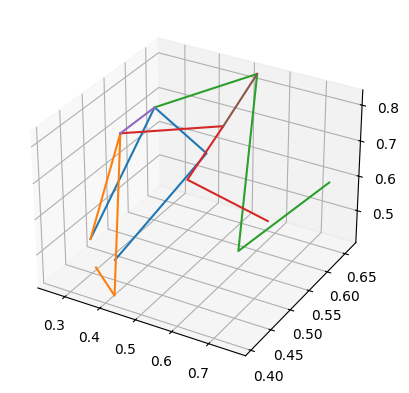

In [13]:
fig = plt.figure()
ax = plt.axes(projection='3d')
for line in lines:
    ax.plot3D(
        [zipped[0][i] for i in range(len(zipped[0])) if i in line],
        [zipped[1][i] for i in range(len(zipped[1])) if i in line],
        [zipped[2][i] for i in range(len(zipped[2])) if i in line],
    )
plt.show()

In [14]:
angle_shoulder


35.787